In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from os import path
import itertools
import requests
from bs4 import BeautifulSoup
from io import StringIO
from matplotlib.font_manager import FontProperties

In [21]:
fontP = FontProperties()
fontP.set_size('small')

In [2]:
%matplotlib inline

In [3]:
def get_word(word):
    old_word = word
    word = word.strip()
    word = word.lower()
    word = word.replace(" ", "_")
    first_four = "/".join(word[:5])
    while True:
        request = requests.get("https://projects.fivethirtyeight.com/reddit-data/{}/{}.csv".format(first_four, word))
        if request.status_code == requests.codes.NOT_FOUND:
            print("Word: '{}' was not found.".format(old_word))
            return None

        if request.status_code == requests.codes.ok:
          return pd.read_csv(StringIO(request.text))
        else:
          print("We could not get the word '{}'\nsleeping for 10s ...".format(old_word))
          sleep(10)

def get_words(words):
    frames = [get_word(words[0])]
    for word in words[1:]:
        df = get_word(word)
        if df is not None:
          frames.append(df.ngram_fraction)
        else:
            frames.append(df)
    valid_words = []
    valid_frames = []
    for i, frame in enumerate(frames):
        if frame is not None:
            valid_words.append(words[i])
            valid_frames.append(frames[i])
    if not valid_frames:
        print("None of the words requested were found.")
        return None
    if len(valid_frames) > 1:
      df = pd.concat(frames, axis=1)
    else:
      df = frames[0]
    df.columns = ["date"] + [x.strip().replace(" ", "_") for x in valid_words]
    df.set_index("date", inplace=True)
    return df

In [4]:
data = get_word("African American")
data.tail()

,date,ngram_fraction
2873,2015-08-27,0.000003
2874,2015-08-28,0.000002
2875,2015-08-29,0.000003
2876,2015-08-30,0.000003
2877,2015-08-31,0.000003


In [5]:
data = get_word("meh")
data.tail()

,date,ngram_fraction
2873,2015-08-27,0.000030
2874,2015-08-28,0.000031
2875,2015-08-29,0.000031
2876,2015-08-30,0.000030
2877,2015-08-31,0.000031


In [6]:
data = get_words(["monocultural", "mono-cultural", "mono cultural", "monoculturals", 
                  "biracial", "bi-racial", "bi racial", "biracials", 
                 "interracial, inter-racial", "inter racial", "interracials", 
                 "multiracial", "multi-racial", "multi racial", "multiracials", 
                 "multiethnic", "multi-ethnic", "multi ethnic", "multiethnics", 
                 "multicultural", "multi-cultural", "multi cultural", "multiculturals", 
                 "multiculturalism", "multi-culturalism", "multi culturalism", "multiculturalisms"])

Word: 'mono-cultural' was not found.
Word: 'mono cultural' was not found.
Word: 'monoculturals' was not found.
Word: 'bi racial' was not found.
Word: 'biracials' was not found.
Word: 'interracial, inter-racial' was not found.
Word: 'inter racial' was not found.
Word: 'interracials' was not found.
Word: 'multi-racial' was not found.
Word: 'multi racial' was not found.
Word: 'multiracials' was not found.
Word: 'multi ethnic' was not found.
Word: 'multiethnics' was not found.
Word: 'multi cultural' was not found.
Word: 'multiculturals' was not found.
Word: 'multi culturalism' was not found.
Word: 'multiculturalisms' was not found.


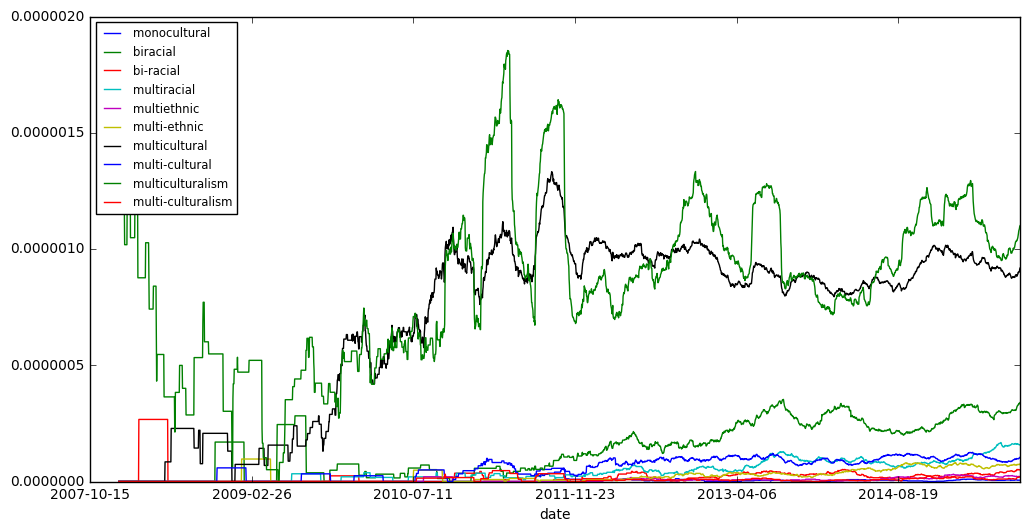

In [29]:
days_to_average_over = 90
smoothed_data = data.rolling(window=days_to_average_over).mean()
axis = smoothed_data.plot()
fig = plt.gcf()
fig.set_size_inches((12,6))
_ = axis.legend(prop=fontP, loc="best")